In [1]:
# Titanic Multi-Model Training & Prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [2]:
# 1. Load Data
titanic_tr= pd.read_csv("C:\\Data_Science\\Prodigy_Tasks\\data-science-datasets\\Task 2\\train.csv")
titanic_tst = pd.read_csv("C:\\Data_Science\\Prodigy_Tasks\\data-science-datasets\\Task 2\\test.csv") 


In [3]:
# Mark source
titanic_tr['source'] = 'train'
titanic_tst['source'] = 'test'
titanic_tst['Survived'] = None  # placeholder so we can combine

In [4]:
titanic_tr.shape

(891, 13)

In [5]:
titanic_tst.shape

(418, 13)

In [6]:
# Combine for preprocessing
titanic = pd.concat([titanic_tr, titanic_tst], ignore_index=True)

In [7]:
titanic.shape

(1309, 13)

In [8]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    object 
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  source       1309 non-null   object 
dtypes: float64(2), int64(4), object(7)
memory usage: 133.1+ KB


In [9]:
titanic.duplicated().sum()

0

In [10]:
titanic.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
source            0
dtype: int64

In [11]:
titanic.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,source
count,1309.000000,891.0,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,1309
unique,NaN,2.0,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3,2
top,NaN,0.0,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,train
freq,NaN,549.0,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,891
mean,655.000000,NaN,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN,NaN
std,378.020061,NaN,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN,NaN
min,1.000000,NaN,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,328.000000,NaN,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN
50%,655.000000,NaN,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN
75%,982.000000,NaN,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,NaN


In [15]:
# 2. Feature Engineering

# A. Extract Title
titanic['Title'] = titanic['Name'].str.extract('([A-Za-z]+)\.', expand=False)
titanic['Title'] = titanic['Title'].replace(
    ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev',
     'Sir', 'Jonkheer', 'Dona'], 'Rare'
)
titanic['Title'] = titanic['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# B. Family Size
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1

# C. IsAlone
titanic['IsAlone'] = (titanic['FamilySize'] == 1).astype(int)

# D. CabinLetter
titanic['CabinLetter'] = titanic['Cabin'].str[0]

# E. Bin Age
titanic['AgeBin'] = pd.cut(titanic['Age'], bins=[0, 12, 20, 40, 60, 80],
                           labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

# F. Bin Fare
titanic['FareBin'] = pd.qcut(titanic['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

In [16]:
titanic.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479,1.883881,0.603514
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668,1.583639,0.489354
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800,1.000000,0.000000
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000,2.000000,1.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,11.000000,1.000000


In [17]:
titanic.describe(include=object)

,Survived,Name,Sex,Ticket,Cabin,Embarked,source,Title,CabinLetter
count,891,1309,1309,1309,295,1307,1309,1309,295
unique,2,1307,2,929,186,3,2,5,8
top,0,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S,train,Mr,C
freq,549,2,843,11,6,914,891,757,94


In [18]:
infodf = pd.DataFrame({"columns":titanic.columns,
                       "unique_values":titanic.nunique(dropna = True),
                       "data_type" : titanic.dtypes})
infodf  

,columns,unique_values,data_type
PassengerId,PassengerId,1309,int64
Survived,Survived,2,object
Pclass,Pclass,3,int64
Name,Name,1307,object
Sex,Sex,2,object
Age,Age,98,float64
SibSp,SibSp,7,int64
Parch,Parch,8,int64
Ticket,Ticket,929,object
Fare,Fare,281,float64


In [19]:
titanic.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
source            0
Title             0
FamilySize        0
IsAlone           0
CabinLetter    1014
AgeBin          263
FareBin           1
dtype: int64

In [20]:
titanic['Age'].skew(), titanic['Age'].kurt()

(0.40767455974362266, 0.1469476357378139)

In [21]:
# 3. Handle Missing Values
titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
titanic['Embarked'].fillna(titanic['Embarked'].mode()[0], inplace=True)
titanic['Fare'].fillna(titanic['Fare'].median(), inplace=True)
titanic['Cabin'].fillna('Unknown', inplace=True)
titanic['CabinLetter'].fillna('U', inplace=True)

In [22]:
# 4. Encode Categorical Variables
label_cols = ['Sex', 'Embarked', 'Title', 'CabinLetter', 'AgeBin', 'FareBin']
for col in label_cols:
    titanic[col] = titanic[col].astype('category').cat.codes

In [23]:
pd.crosstab(titanic['Embarked'],titanic['Survived'],normalize='index')*100

Survived,0,1
Embarked,,
0,44.642857,55.357143
1,61.038961,38.961039
2,66.099071,33.900929


In [24]:
# Keep original
#titanic['Embarked_original'] = titanic['Embarked']

# Encode for modeling
#titanic['Embarked'] = titanic['Embarked'].astype('category').cat.codes


#sns.countplot(x='Survived', hue='Embarked_original', data=titanic)
#plt.title('Survival Count by Embark')
#plt.xlabel('Survived (0 = No, 1 = Yes)')
#plt.ylabel('Count')
#plt.show()

In [25]:
# Step 1: Keep original embarkation as string (for plotting)
#titanic['Embarked_original'] = titanic['Embarked'].copy()

# Step 2: Fill missing values with a label
#titanic['Embarked_original'] = titanic['Embarked_original'].fillna('Unknown')

# Step 3: Encode the column for modeling (safe)
#titanic['Embarked'] = titanic['Embarked'].astype('category').cat.codes

# Step 4: Plot without errors
#import seaborn as sns
#import matplotlib.pyplot as plt

#sns.countplot(x='Survived', hue='Embarked_original', data=titanic)
#plt.title('Survival Count by Embark')
#plt.xlabel('Survived (0 = No, 1 = Yes)')
#plt.ylabel('Count')
#plt.show()


In [26]:
titanic.isna().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
source           0
Title            0
FamilySize       0
IsAlone          0
CabinLetter      0
AgeBin           0
FareBin          0
dtype: int64

In [27]:
noof_survival = titanic['Survived'].value_counts()
noof_survival

Survived
0    549
1    342
Name: count, dtype: int64

In [28]:
pd.crosstab(titanic['Sex'],titanic['Survived']) #Out of 314 women who were onboarded in Titanic 233 survived. and 109 males survived from 577,i.e only 18% of Males survived and 74% of women, the proportion of male and female survival is different due to unavailability of ships to save people and males have given the priority to save womens 

Survived,0,1
Sex,,
0,81,233
1,468,109


In [29]:
from scipy.stats import chi2_contingency

table = pd.crosstab(titanic['Sex'], titanic['Survived'])
chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi2: {chi2}, p-value: {p}") #----# p value is less than 5% hence there is statistically significant relationsip between Sex and Survived column.

Chi2: 260.71702016732104, p-value: 1.1973570627755645e-58


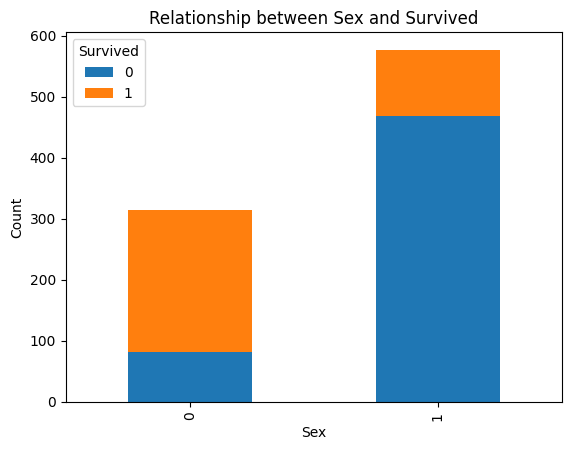

In [30]:
pd.crosstab(titanic['Sex'], titanic['Survived']).plot(kind='bar', stacked=True)
plt.title('Relationship between Sex and Survived')
plt.ylabel('Count')
plt.show()

In [31]:
ticket_class = titanic['Pclass'].value_counts()
ticket_class

Pclass
3    709
1    323
2    277
Name: count, dtype: int64

In [32]:
table = pd.crosstab(titanic['Pclass'], titanic['Survived'])
chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi2: {chi2}, p-value: {p}")  # p value is less than 5% hence there is statistically significant relationsip between Passenger_class and Survived column. 


Chi2: 102.88898875696056, p-value: 4.549251711298793e-23


In [33]:
pd.crosstab(titanic['Pclass'],titanic['Survived'])

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [34]:
pd.crosstab(titanic['Pclass'],titanic['Survived'],normalize='index')*100 # we saw here that there is a positive correlation among passenger ticket class and Survival rate as better the ticket class chances of survival are better 

Survived,0,1
Pclass,,
1,37.037037,62.962963
2,52.717391,47.282609
3,75.763747,24.236253


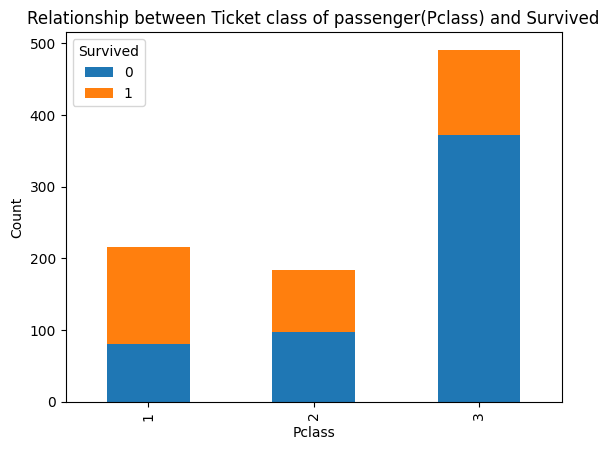

In [35]:
pd.crosstab(titanic['Pclass'], titanic['Survived']).plot(kind='bar', stacked=True)
plt.title('Relationship between Ticket class of passenger(Pclass) and Survived')
plt.ylabel('Count')
plt.show() #------pclass 3 is most affected class as only 24.23% people got survived. 

<Axes: xlabel='Survived', ylabel='Pclass'>

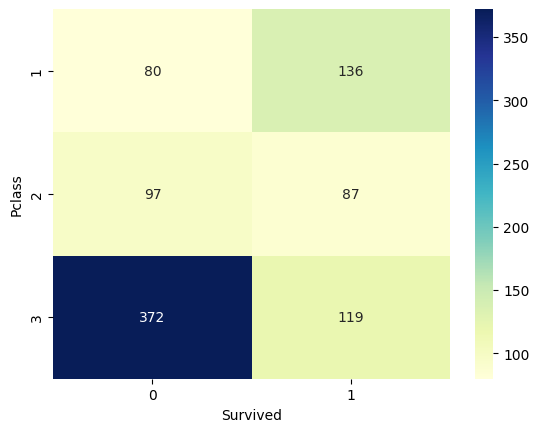

In [36]:
ctPc = pd.crosstab(titanic['Pclass'], titanic['Survived'])
sns.heatmap(ctPc, annot=True, fmt='d', cmap='YlGnBu')

In [37]:
table = pd.crosstab(titanic['SibSp'], titanic['Survived'])
chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi2: {chi2}, p-value: {p}")   # p value is less than 5% hence there is statistically significant relationsip between SibSp and Survived column. 

Chi2: 37.2717929152043, p-value: 1.5585810465902147e-06


<Axes: xlabel='Survived', ylabel='SibSp'>

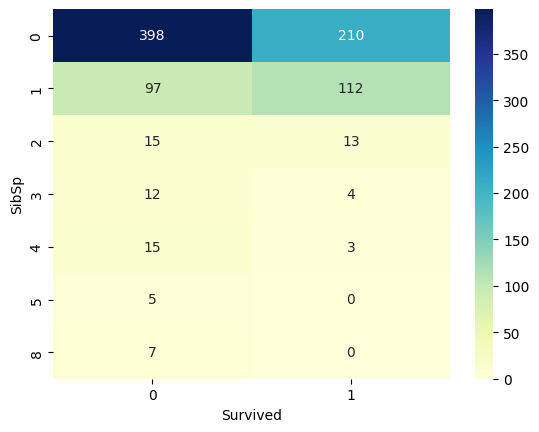

In [38]:
ctSibSp = pd.crosstab(titanic['SibSp'], titanic['Survived'])
sns.heatmap(ctSibSp, annot=True, fmt='d', cmap='YlGnBu')

In [39]:
table = pd.crosstab(titanic['Parch'], titanic['Survived'])
chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi2: {chi2}, p-value: {p}") #There is no significant relationship between Parch and Survived column as p-value is greater than 5%.

Chi2: 27.925784060236168, p-value: 9.703526421039996e-05


In [40]:
# 5. Split back to train & test
titanic_tr = titanic[titanic['source'] == 'train'].drop(columns=['source'])
titanic_tst = titanic[titanic['source'] == 'test'].drop(columns=['source', 'Survived'])

X = titanic_tr.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'])
y = titanic_tr['Survived']


In [41]:
# 6. Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [42]:
print(y_train.head())
print(y_train.dtype)
print(y_train.unique())  # or np.unique(y_train)

331    0
733    0
382    0
704    0
813    0
Name: Survived, dtype: object
object
[0 1]


In [43]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [44]:
# 7. Train Multiple Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    

C:\Users\Spring 2\anaconda3\envs\notebook-6.1.1\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8101
Random Forest Accuracy: 0.8380
Gradient Boosting Accuracy: 0.8268


In [45]:
# 8. Pick Best Model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with Accuracy {results[best_model_name]:.4f}")


Best Model: Random Forest with Accuracy 0.8380


In [46]:
# 9. Predict on Test Data
test_preds = best_model.predict(titanic_tst.drop(columns=['Name', 'Ticket', 'Cabin']))

In [47]:
# Create submission file
submission = pd.DataFrame({
    'PassengerId': titanic_tst['PassengerId'],
    'Survived': test_preds.astype(int)
})

submission.to_csv("titanic_predictions.csv", index=False)
print("\nPredictions saved to titanic_predictions.csv")


Predictions saved to titanic_predictions.csv


In [48]:
# Agreement vs Difference
model_preds = pd.read_csv("titanic_predictions.csv")
baseline_preds = pd.read_csv("C:\\Data_Science\\Prodigy_Tasks\\data-science-datasets\\Task 2\\gender_submission.csv")

merged = model_preds.merge(baseline_preds, on="PassengerId", suffixes=('_model', '_baseline'))

agreement_rate = (merged['Survived_model'] == merged['Survived_baseline']).mean() * 100
difference_count = (merged['Survived_model'] != merged['Survived_baseline']).sum()

print(f"Agreement: {agreement_rate:.2f}%")
print(f"Number of different predictions: {difference_count}")


Agreement: 86.84%
Number of different predictions: 55


In [49]:
# Passenger analysis where predictions differ
test_data = titanic_tst

# Keep PassengerId and predictions from merged
diff_passengers = merged[merged['Survived_model'] != merged['Survived_baseline']][['PassengerId', 'Survived_model', 'Survived_baseline']]

# Merge with passenger details
diff_details = test_data.merge(diff_passengers, on='PassengerId')

diff_details.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,CabinLetter,AgeBin,FareBin,Survived_model,Survived_baseline
0,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,Unknown,2,3,2,0,8,3,0,0,1
1,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,Unknown,2,3,3,0,8,2,1,0,1
2,910,3,"Ilmakangas, Miss. Ida Livija",0,27.0,1,0,STON/O2. 3101270,7.9250,Unknown,2,1,2,0,8,2,1,0,1
3,913,3,"Olsen, Master. Artur Karl",1,9.0,0,1,C 17368,3.1708,Unknown,2,0,2,0,8,0,0,1,0
4,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",0,28.0,1,2,W./C. 6607,23.4500,Unknown,2,3,4,0,8,-1,2,0,1


In [50]:
both_survive = ((merged['Survived_model'] == 1) & (merged['Survived_baseline'] == 1)).mean() * 100
both_not_survive = ((merged['Survived_model'] == 0) & (merged['Survived_baseline'] == 0)).mean() * 100

print(f"Both predict survive: {both_survive:.2f}%")
print(f"Both predict not survive: {both_not_survive:.2f}%")

Both predict survive: 28.71%
Both predict not survive: 58.13%
